In [1]:
import os
os.environ["OMP_NUM_THREADS"] = "32"

In [2]:
from graph_tool.all import *
import pandas as pd
import numpy as np
import scipy as sp
from sklearn.covariance import LedoitWolf, OAS
#import matplotlib.pyplot as py
#import seaborn as sns
import statsmodels.api as sm

In [3]:
### Input expression data

gene_expr = pd.read_table("../data/GXEpaper/GeneCounts/VOOMCounts_CPM1_head_hsctrl_covfree_4svs_CORRECT_Jan8.21.txt")

### Input covariates

covariates = pd.read_table("../data/GXEpaper/Covariates_forGEMMA_Jan82021.txt", sep = ",")

ID_C = covariates.query('treatment == 1')["ID"]
ID_HS = covariates.query('treatment == 1')["ID"]

gene_expr_dict = {"C": gene_expr[ID_C].T, "HS": gene_expr[ID_HS].T}

In [4]:
X_C = (gene_expr_dict["C"] - gene_expr_dict["C"].mean()) / np.sqrt(gene_expr_dict["C"].var())
oa = OAS(store_precision=True, assume_centered=True)
regularized_C_corr = oa.fit(X_C)

X_HS = (gene_expr_dict["HS"] - gene_expr_dict["HS"].mean()) / np.sqrt(gene_expr_dict["HS"].var())
oa = OAS(store_precision=True, assume_centered=True)
regularized_HS_corr = oa.fit(X_HS)

gene_expr_OAS_corr = {"C": regularized_C_corr, 
                      "HS": regularized_HS_corr}



In [5]:
n_genes = gene_expr_OAS_corr["C"].covariance_.shape[1]

In [6]:
# g = Graph(directed=False)
# g.add_vertex(n = n_genes)

# pcor = g.new_ep("double", 0)
# corr = g.new_ep("double", 0)
# pval = g.new_ep("double", 0)
# genes = g.new_vertex_property("string", np.array(gene_expr["Gene"]))
# g.vertex_properties["genes"] = genes

# for i in range(n_genes):
#     print(i)
#     for j in range(i):
#         pearson_r = sp.stats.pearsonr(X_C[i], X_C[j])
#         if(pearson_r[1] < 1e-8):
#             g.add_edge(i, j)
#             e = g.edge(i, j)
#             pcor[e] = -gene_expr_OAS_corr["C"].precision_[i, j]/np.sqrt(gene_expr_OAS_corr["C"].precision_[i, i]*gene_expr_OAS_corr["C"].precision_[j, j])
#             corr[e] = gene_expr_OAS_corr["C"].covariance_[i, j]/np.sqrt(gene_expr_OAS_corr["C"].covariance_[i, i]*gene_expr_OAS_corr["C"].covariance_[j, j])
#             pval[e] = pearson_r[1]

# g.edge_properties["correlation"] = corr
# g.edge_properties["precision"] = pcor
# g.edge_properties["pvalue"] = pval

# pcor = g.edge_properties["precision"]
# pcor_z = g.new_ep("double", 0)
# g.edge_properties["pcor_z"] = pcor_z
# pcor_z.a = np.arctanh(abs(pcor.a)) 
# pcor_z.a = pcor_z.a/max(pcor_z.a)

# g.save("full_voom_regularized_correlations_precisions_pvalues_cutoff_1e-6.xml.gz")

In [7]:
g = load_graph("full_voom_regularized_correlations_precisions_pvalues_cutoff_1e-6.xml.gz")

In [10]:
g_significant = GraphView(g, g.get_total_degrees(g.get_vertices()) > 1 )
g_significant = GraphView(g_significant, g_significant.get_total_degrees(g_significant.get_vertices()) > 1 )
g_significant

<GraphView object, undirected, with 6163 vertices and 654913 edges, 1 internal vertex property, 4 internal edge properties, edges filtered by (<EdgePropertyMap object with value type 'bool', for Graph 0x7f9805222c70, at 0x7f9805155730>, False), vertices filtered by (<VertexPropertyMap object with value type 'bool', for Graph 0x7f9805222c70, at 0x7f9805155700>, False), at 0x7f9805222c70>

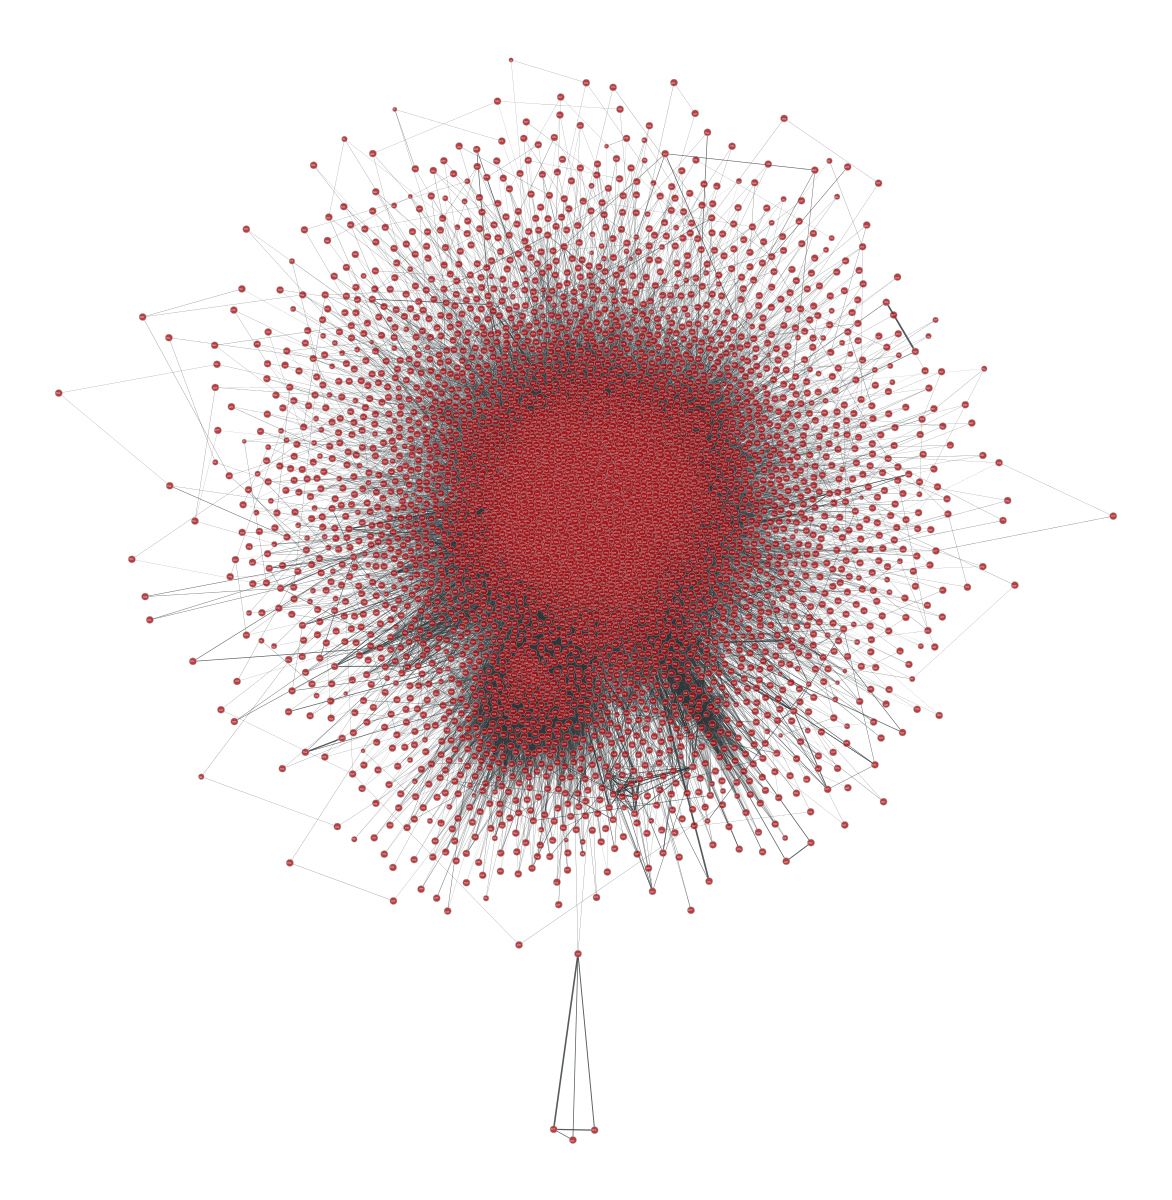

<VertexPropertyMap object with value type 'vector<double>', for Graph 0x7f9805222c70, at 0x7f980514af10>

In [11]:
graph_draw(g_significant, vertex_text=g.vertex_index, edge_pen_width=pcor_z)

In [12]:
gf = g.copy()

In [13]:
# Filtering edges
pval = gf.edge_properties["pvalue"]
sign = gf.new_ep("bool", True)
sign.a = np.array(pval.a < 1e-10)
gf.set_edge_filter(sign)
gf.purge_edges()

# Keeping largest component
comp, hist = label_components(gf)
main_component = gf.new_vp("bool", (comp.a == np.where(hist == max(hist))[0][0]))
gf.vertex_properties["main_component"] = main_component
gf.set_vertex_filter(main_component)
gf.purge_vertices()

In [15]:
N = len(gf.get_vertices())
Et = (N * N - N)/2
E = len(gf.get_edges())
E/Et

0.030274097012257216

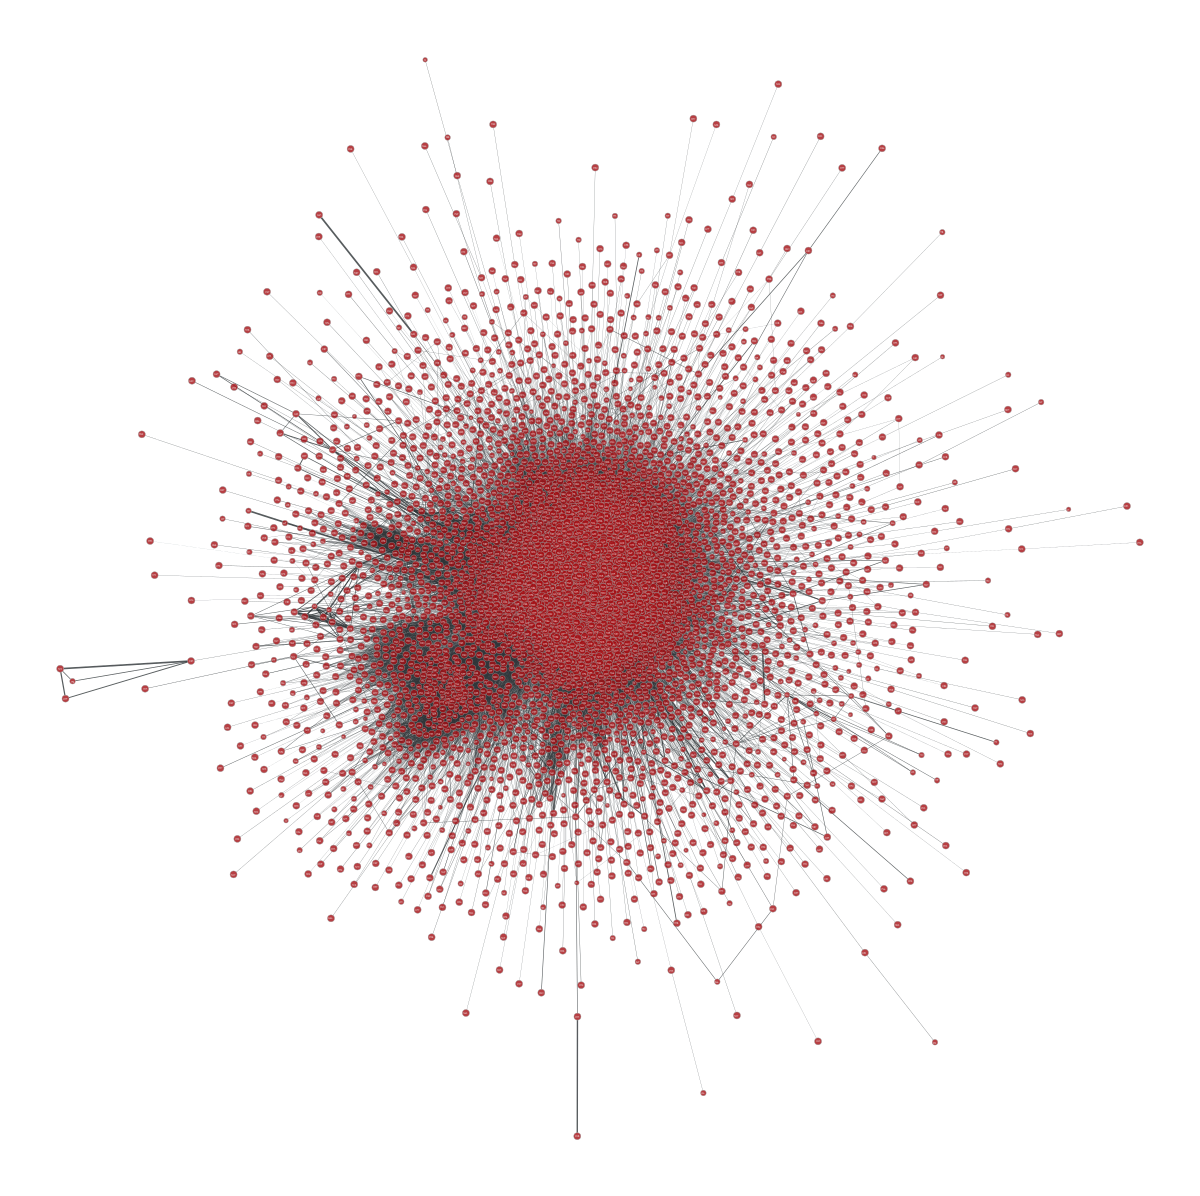

<VertexPropertyMap object with value type 'vector<double>', for Graph 0x7f980514a640, at 0x7f980516fac0>

In [16]:
graph_draw(gf, vertex_text=gf.vertex_index, edge_pen_width=gf.edge_properties["pcor_z"])

In [ ]:
pcor_z = gf.edge_properties["pcor_z"]
n_trials = 10
state_nn_min_list = []
for i in range(n_trials):
    print(i)
    state_min = minimize_blockmodel_dl(gf, state_args=dict(recs=[pcor_z],
                                                           rec_types=["real-normal"]))
    state_nn_min_list.append(state_min)

0
1
2
3
4


In [20]:
# improve solution with merge-split
# state_min = state_min.copy(bs=state_min.get_bs() + [np.zeros(1)] * 4, sampling=True)

ret_nn = []
state_nn_mcmc_list = []
for j in range(n_trials):
    print(j)
    for i in range(200):
        state = state_nn_min_list[j].copy(sampling = True)
        x = state.multiflip_mcmc_sweep(niter=20, beta=np.inf)
        state_nn_mcmc_list.append(state)
        ret_nn.append(x)

0


/Genomics/grid/users/damelo/.conda/envs/gt/lib/python3.9/site-packages/graph_tool/inference/blockmodel.py:481: UserWarning: unrecognized keyword arguments: ['sampling']
  warnings.warn("unrecognized keyword arguments: " +


1
2
3
4
5
6
7
8
9


In [21]:
for j in range(n_trials):
    print(state_nn_mcmc_list[j].entropy())

-297315.5047921334
-297423.0855664616
-297318.93017453235
-297454.57106593763
-297337.1589710286
-297323.7188454964
-297452.8328005064
-297390.3190210297
-297449.19527320244
-297316.68717042496


In [22]:
state_min_nn = state_nn_mcmc_list[0]

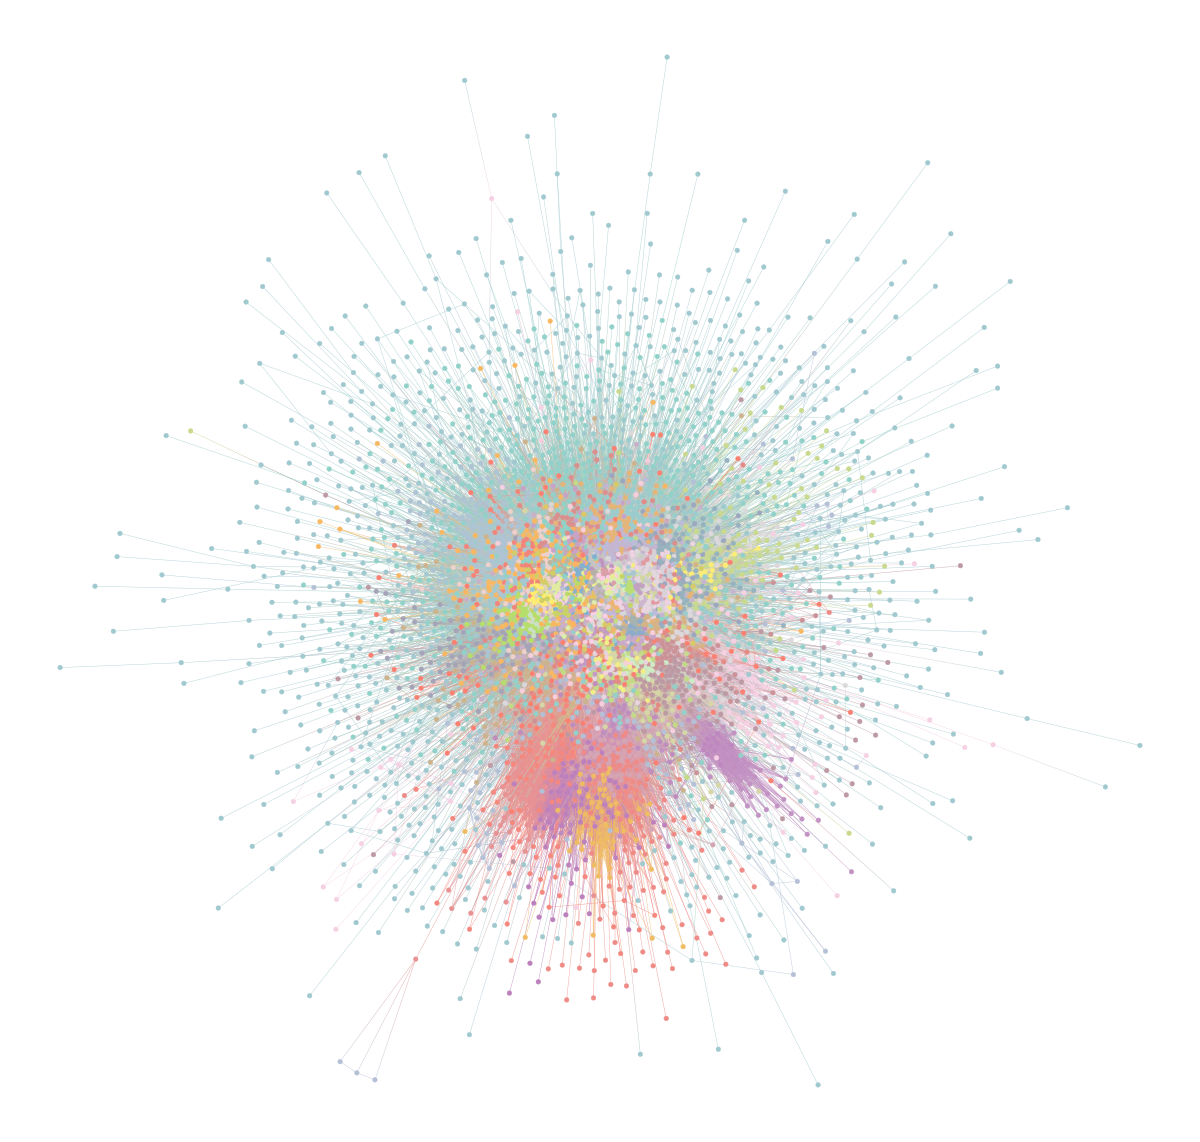

<VertexPropertyMap object with value type 'vector<double>', for Graph 0x7f980514a640, at 0x7f96f8fce850>

In [23]:
state_min_nn.draw()

In [39]:
def create_Block_df(g, state):
    genes = g.vertex_properties["genes"]
    pcor_z = g.edge_properties["pcor_z"]
    block_df = pd.DataFrame(columns=('Gene', "Degree", "E_pcor_z", 'Block'))
    for v in g.vertex_index:
        line = [genes[v]]
        line.append(g.get_total_degrees([v])[0])
        line.append(np.mean(g.get_all_edges(v, [pcor_z] )[:,2]))
        line.append(state.get_blocks()[v])
        block_df.loc[v] = line
    return block_df

In [41]:
block_df = create_Block_df(gf, state_min_nn)
block_df.to_csv("../data/5524genes-non_hierarchical_sbm-fit_df.csv")

In [ ]:
pcor_z = gf.edge_properties["pcor_z"]
n_trials = 10
state_min_list = []
for i in range(n_trials):
    print(i)
    state_min = minimize_nested_blockmodel_dl(gf, state_args=dict(recs=[pcor_z],
                                                                  rec_types=["real-normal"]))
    state_min_list.append(state_min)

In [49]:
# improve solution with merge-split
# state_min = state_min.copy(bs=state_min.get_bs() + [np.zeros(1)] * 4, sampling=True)

ret = []
state_mcmc_list = []
for j in range(n_trials):
    print(j)
    for i in range(200):
        state = state_min_list[j].copy(sampling = True)
        x = state.multiflip_mcmc_sweep(niter=20, beta=np.inf)
        state_mcmc_list.append(state)
        ret.append(x)

0
1
2
3
4
5
6
7
8
9


In [51]:
for j in range(n_trials):
    print(state_mcmc_list[j].entropy())

-296252.3734740218
-296239.52598639805
-296234.48970327957
-296583.4826213035
-296274.53009304206
-296242.03508025006
-296338.80773038144
-296250.14849370904
-296265.5570873077
-296311.7127777108


In [53]:
state_min = state_mcmc_list[3]

In [54]:
#state_min.delete_level(5)
levels = state_min.get_levels()
len(levels)

5

In [55]:
levels = state_min.get_levels()
for s in levels:
    print(s)

<BlockState object with 380 blocks (102 nonempty), degree-corrected, with 1 edge covariate, for graph <Graph object, undirected, with 5524 vertices and 461817 edges, 2 internal vertex properties, 4 internal edge properties, edges filtered by (<EdgePropertyMap object with value type 'bool', for Graph 0x7fc0ac472f70, at 0x7fc0ac47b0d0>, False), vertices filtered by (<VertexPropertyMap object with value type 'bool', for Graph 0x7fc0ac472f70, at 0x7fc0ac472940>, False), at 0x7fc0ac472f70>, at 0x7fbfa85ae400>
<BlockState object with 32 blocks (21 nonempty), with 1 edge covariate, for graph <Graph object, undirected, with 380 vertices and 4054 edges, at 0x7fbfa84c1c10>, at 0x7fbfa87905b0>
<BlockState object with 7 blocks (6 nonempty), with 1 edge covariate, for graph <Graph object, undirected, with 32 vertices and 230 edges, at 0x7fbfa8790e80>, at 0x7fbfa8790310>
<BlockState object with 4 blocks (3 nonempty), with 1 edge covariate, for graph <Graph object, undirected, with 7 vertices and 21 

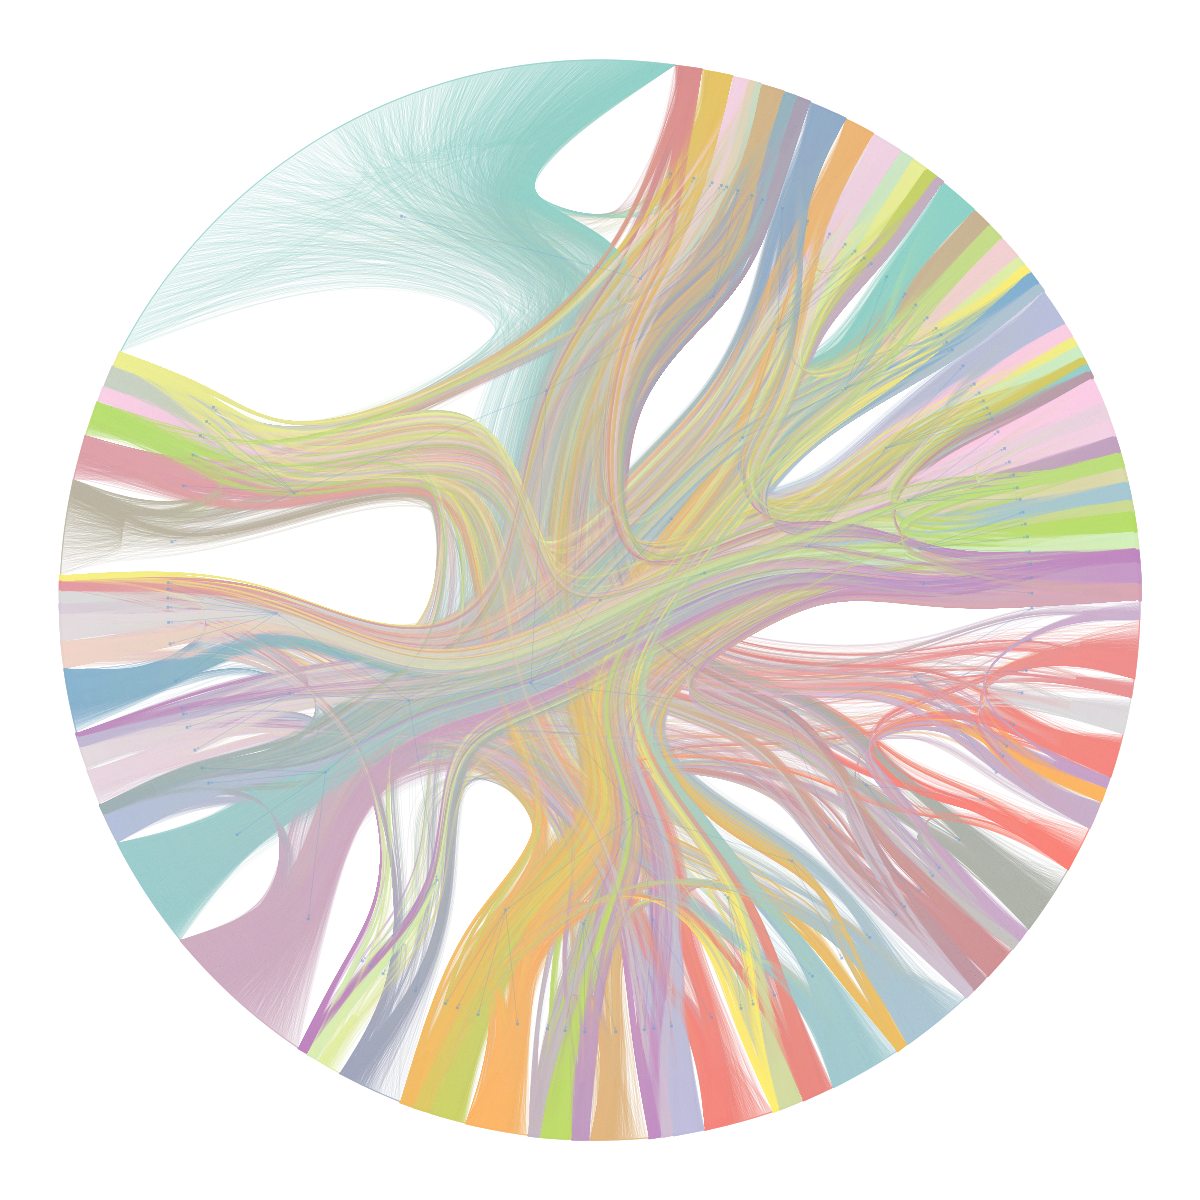

(<VertexPropertyMap object with value type 'vector<double>', for Graph 0x7fc0ac472f70, at 0x7fbedcd4c640>,
 <Graph object, directed, with 5657 vertices and 5656 edges, at 0x7fbfbe2ff520>,
 <VertexPropertyMap object with value type 'vector<double>', for Graph 0x7fbfbe2ff520, at 0x7fbedcd47640>)

In [56]:
state_min.draw()

<AxesSubplot:ylabel='Count'>

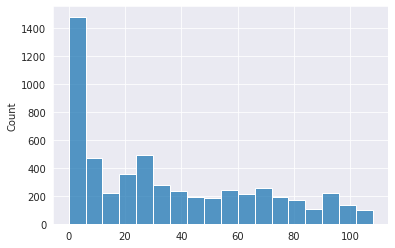

In [106]:
sns.histplot(state_min_non_nested.b.a)

In [70]:
state_min.draw(output="../plots/5524genes-hsbm-fit.png")


(<VertexPropertyMap object with value type 'vector<double>', for Graph 0x7fc0ac472f70, at 0x7fbedcd6fd90>,
 <Graph object, directed, with 5657 vertices and 5656 edges, at 0x7fbedcd4c340>,
 <VertexPropertyMap object with value type 'vector<double>', for Graph 0x7fbedcd4c340, at 0x7fbedcd6cf40>)

In [75]:
def get_group(x, state):
    levels = state.get_levels()
    n_levels = len(levels)
    r = np.zeros(n_levels)
    r[0] = levels[0].get_blocks()[x]
    for i in range(1, n_levels):
        r[i] = levels[i].get_blocks()[r[i-1]]
    r = r.astype(int)
    return r
def create_nestedBlock_df(g, state):
    genes = g.vertex_properties["genes"]
    pcor_z = g.edge_properties["pcor_z"]
    nested_block_df = pd.DataFrame(columns=('Gene', "Degree", "E_pcor_z", 'B1', "B2", "B3", "B4", "B5"))
    for v in g.vertex_index:
        line = [genes[v]]
        line.append(g.get_total_degrees([v])[0])
        line.append(np.mean(g.get_all_edges(v, [pcor_z] )[:,2]))
        [line.append(i) for i in get_group(v, state)]
        nested_block_df.loc[v] = line
    return nested_block_df

In [76]:
nested_block_df = create_nestedBlock_df(gf, state_min)

In [69]:
nested_block_df.to_csv("../data/5524genes-hsbm-fit_df.csv")

In [68]:
nested_block_df

Gene Degree  E_pcor_z  B1  B2 B3 B4 B5
0     FBgn0031081    199  0.026147   0   0  0  3  1
1     FBgn0052350      8  0.054538   1   1  1  1  0
2     FBgn0024733    997  0.017934   2   2  2  2  0
3     FBgn0040372     19  0.033927   3   3  4  1  0
4     FBgn0024989      2  0.111537   1   1  1  1  0
...           ...    ...       ...  ..  .. .. .. ..
5519  FBgn0040723     41  0.073085  70   9  5  1  0
5520  FBgn0031313     40  0.132077  94  16  4  1  0
5521  FBgn0031305    703  0.021867  52  20  2  2  0
5522  FBgn0016926     93  0.039171  96  11  1  1  0
5523  FBgn0003310      9  0.078904   1   1  1  1  0

[5524 rows x 8 columns]